In [1]:
import sqlite3, json, os, glob
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [4]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.regression.mixed_linear_model import MixedLMResults

In [5]:
from scipy import stats

In [6]:
csv_dir = './output'

In [7]:
csv_list_June = glob.glob(os.path.join(csv_dir, '*csv'))
for curr_ind, curr_csv in enumerate(csv_list):
    curr_df = pd.read_csv(curr_csv)
    if curr_ind == 0:
        data_df_June = curr_df
    else:
        data_df_June = data_df_June.append(curr_df).reset_index(drop=True)
    



NameError: name 'csv_list' is not defined

In [ ]:
def clean_data(data_df):
    outer_counter = 0
    for curr_sess_ind, curr_sess in enumerate(data_df['session'].unique()):
        tmp2 = data_df[data_df['session']==curr_sess]
        counter = 0
        for curr_block_data in tmp2['data'].values:
            curr_df = pd.read_json(curr_block_data)
            if counter == 0:
                counter += 1
                all_blocks_data = curr_df
            else:
                all_blocks_data = all_blocks_data.append(curr_df).reset_index(drop=True)
        
        urls = all_blocks_data['url'].dropna()
        if urls.values[0]  !=  []:
            Prolific_PID = urls.values[0]['observation']

            if ('condition' in all_blocks_data.columns) & ('response' in all_blocks_data.columns):

                # Only retain the response lines
                curr_sub_resp_data = all_blocks_data[((all_blocks_data['sender']=='Test_no_img') | 
                                         (all_blocks_data['sender']=='Test_w_img')) &
                                       (~all_blocks_data['Condition'].isna())&
                                       (~all_blocks_data['response'].isna())]
                curr_sub_resp_data['observation'] = Prolific_PID

                if outer_counter == 0:
                    outer_counter += 1
                    all_subs_resp_data = curr_sub_resp_data
                else:
                    all_subs_resp_data = all_subs_resp_data.append(curr_sub_resp_data).reset_index(drop=True)
    return all_subs_resp_data

In [8]:
subs_response_June = clean_data(data_df_June)


/Users/qilin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Determine the number of participants to include

In [9]:
len(subs_response_June['PROLIFIC_PID'].unique())

66

In [10]:
id_count_June = subs_response_June.groupby(['PROLIFIC_PID','Condition'])['sender'].count().reset_index()
all_conds_June = id_count_June.rename(columns={'sender':'count'})

In [11]:
block_counts_no_thresh = all_conds_June.groupby('PROLIFIC_PID').count().reset_index()

In [12]:
subs_w_less12_blocks = block_counts_no_thresh[block_counts_no_thresh['count']<12]['PROLIFIC_PID'].unique()

In [13]:
subs_w_less12_blocks

array(['5b118915e9270900013c298c', '5e9c71729aff220278b4b044',
       '6054b3343ec5a5210314e231', '605986be77c362e33eac85c2',
       '605fa7167feaeaaa86844919', '60674e08ad872b4cd378a9df',
       '6088e93caec985c1921710af', '608d8bf2625fc7fc51e78ae8',
       '60b7e2622673b3a36a7dc3b0', '60d08b8d740bfcc4c5f6d513',
       '60d3896732b90c075c5743f1', '60d53b2849eed3b078015d0c',
       '60d63d070abc4e4fee085bd3', '60d73a6d8d7122148b84c67a',
       '60d7ceb2b2211a1ed8e7a9b0', '60d87c9b65b4a1aa922c9747',
       '60d926197259be150e9dda9b', '60dc68e0fdaf76e6ba8daa7b',
       '60dc77a0684f892da794c91e'], dtype=object)

In [14]:
sub_block_count_all_June = all_conds_June[all_conds_June['count']>=32*0.9].groupby('PROLIFIC_PID').count().reset_index()


In [15]:
subs_w_imcomplete_blocks = all_conds_June[all_conds_June['count']<32*0.9]['PROLIFIC_PID'].unique()

In [16]:
[k for k in subs_w_imcomplete_blocks if k not in subs_w_less12_blocks]

['5c808557e07cd1001628cd77']

# Determine the number of remaining participants based on the conditions included

In [17]:
tmp_subs_to_lookat_allconds_June = sub_block_count_all_June[sub_block_count_all_June['count']==12]['PROLIFIC_PID'].values
# Lets find out who came in last (we had one more participant)
timestamp_June = subs_response_June[subs_response_June['PROLIFIC_PID'].isin(tmp_subs_to_lookat_allconds_June)].drop_duplicates(subset=['PROLIFIC_PID']).sort_values(by=['timestamp'])
subs_to_lookat_allconds_June = timestamp_June['PROLIFIC_PID'].values[:-1]

In [18]:
len(tmp_subs_to_lookat_allconds_June)

46

In [19]:
len(subs_to_lookat_allconds_June)

45

In [20]:
# Reorganize trials 
def calc_performance(subj_ID, data_all):
    
    curr_sub_df = data_all[data_all['PROLIFIC_PID']==subj_ID]
    curr_sub_df['img_duration'] = [int(k[-1]) for k in curr_sub_df['Condition'].str.split('_')]
    duration_list = curr_sub_df['img_duration'].unique()
    
    curr_perf_df = pd.DataFrame(columns=['sub','duration', 'hit','fa', 'dprime'])
    
    curr_dur_df_yes = curr_sub_df[curr_sub_df['TrialType']=='YES']

    curr_dur_df_no = curr_sub_df[curr_sub_df['TrialType']=='NO']     
    curr_perf_df.loc[len(curr_perf_df)]={'sub': subj_ID,
                                                 'duration':'all',
                                                 'hit':np.round(np.sum(curr_dur_df_yes['response']=='YES')/len(curr_dur_df_yes),3),
                                                 'fa':np.round(np.sum(curr_dur_df_no['response']=='YES')/len(curr_dur_df_no),3),
                                                 'dprime':np.round(norm.ppf(np.sum(curr_dur_df_yes['response']=='YES')/len(curr_dur_df_yes))-norm.ppf(np.sum(curr_dur_df_no['response']=='YES')/len(curr_dur_df_no)),3)
                
            }
    
    for duration in duration_list:
            curr_dur_df_yes = curr_sub_df[(curr_sub_df['img_duration']==duration)&
                                         (curr_sub_df['TrialType']=='YES')]

            curr_dur_df_no = curr_sub_df[(curr_sub_df['img_duration']==duration)&
                                         (curr_sub_df['TrialType']=='NO')]           
            
            
            
            curr_perf_df.loc[len(curr_perf_df)]={'sub': subj_ID,
                                                 'duration':duration,
                                                 'hit':np.round(np.sum(curr_dur_df_yes['response']=='YES')/len(curr_dur_df_yes),3),
                                                 'fa':np.round(np.sum(curr_dur_df_no['response']=='YES')/len(curr_dur_df_no),3),
                                                 'dprime':np.round(norm.ppf(np.sum(curr_dur_df_yes['response']=='YES')/len(curr_dur_df_yes))-norm.ppf(np.sum(curr_dur_df_no['response']=='YES')/len(curr_dur_df_no)),3)
                
                                                }
    
        
    return curr_perf_df

In [21]:
# Reorganize trials 
def calc_performance_target(subj_ID, data_all):
    
   
    curr_sub_df = data_all[data_all['PROLIFIC_PID']==subj_ID]
    
    condition_list = curr_sub_df['Condition'].unique()        
    
    curr_perf_df = pd.DataFrame(columns=['sub','condition', 'hit','fa', 'dprime'])
    
    for condition in condition_list:
        curr_dur_df_yes = curr_sub_df[(curr_sub_df['Condition']==condition)&
                                     (curr_sub_df['TrialType']=='YES')]

        curr_dur_df_no = curr_sub_df[(curr_sub_df['Condition']==condition)&
                                     (curr_sub_df['TrialType']=='NO')] 
        total_trials = len(curr_dur_df_yes) + len(curr_dur_df_no)

        curr_hit = np.round(np.sum(curr_dur_df_yes['response']=='YES')/len(curr_dur_df_yes),3)
        curr_fa = np.round(np.sum(curr_dur_df_no['response']=='YES')/len(curr_dur_df_no),3)

        if curr_hit == 1:
            curr_hit = 1-1/(2*total_trials)
        elif curr_hit == 0:
            curr_hit = 1/(2*total_trials)

        if curr_fa == 1:
            curr_fa = 1-1/(2*total_trials)
        elif curr_fa == 0:
            curr_fa = 1/(2*total_trials)

        curr_perf_df.loc[len(curr_perf_df)]={'sub': subj_ID,
                                             'condition':condition,
                                             'hit':curr_hit,
                                             'fa':curr_fa,
                                             'dprime':np.round(norm.ppf(curr_hit)-norm.ppf(curr_fa),3)

        }

        
    
    curr_perf_df['duration'] = [int(k[-1]) for k in curr_perf_df['condition'].str.split('_')]
    curr_perf_df['property'] = curr_perf_df['condition'].str[:19]
    curr_perf_df['Dist'] = [k[1] for k in curr_perf_df['property'].str.split('_')]
    curr_perf_df['RE'] = [k[3] for k in curr_perf_df['property'].str.split('_')]
        
    return curr_perf_df

In [22]:
# Summarize performance for a list of subjects
def calc_performance_group(df, sub_list):
    counter=0
    df_filterd = df[df['PROLIFIC_PID'].isin(sub_list)]
    for curr_sub in sub_list:
        curr_df = calc_performance(curr_sub, df_filterd)
        if counter == 0:
            counter += 1
            all_sub_df = curr_df
        else:
            all_sub_df = all_sub_df.append(curr_df).reset_index(drop=True)
    return all_sub_df

In [23]:
# Summarize performance separately for each condition for a list of subjects
def calc_performance_target_group(df, sub_list):
    counter=0
    df_filterd = df[df['PROLIFIC_PID'].isin(sub_list)]
    for curr_sub in sub_list:
        curr_df = calc_performance_target(curr_sub, df_filterd)
        if counter == 0:
            counter += 1
            all_sub_df = curr_df
        else:
            all_sub_df = all_sub_df.append(curr_df).reset_index(drop=True)
    return all_sub_df

In [24]:
June_summary_all = calc_performance_group(subs_response_June, subs_to_lookat_allconds_June)
June_summary_all['Batch'] = 'June'

/Users/qilin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<Figure size 432x432 with 0 Axes>

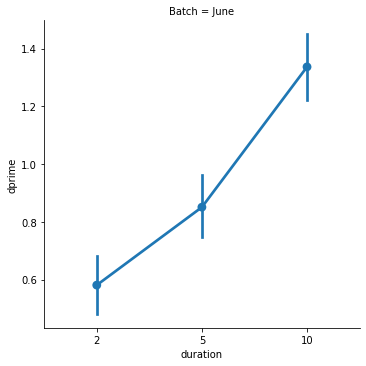

In [28]:
plt.figure(figsize=(6,6))
targets_axes = sns.catplot(x='duration',y='dprime',
            kind = 'point',col='Batch',
              data=June_summary_all[June_summary_all['duration']!='all'])

In [29]:
June_summary_targets = calc_performance_target_group(subs_response_June, subs_to_lookat_allconds_June)
June_summary_targets['Batch'] = 'June'

<Figure size 432x432 with 0 Axes>

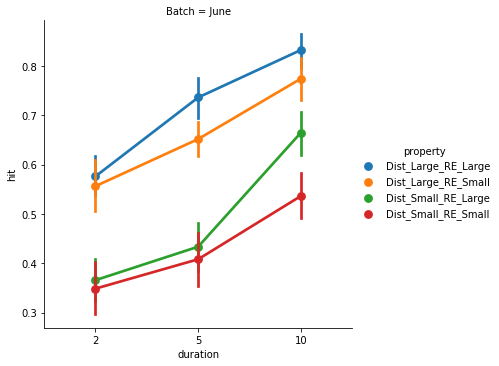

In [30]:
plt.figure(figsize=(6,6))
targets_axes = sns.catplot(x='duration',y='hit',hue='property', hue_order=['Dist_Large_RE_Large','Dist_Large_RE_Small',
                                                             'Dist_Small_RE_Large','Dist_Small_RE_Small'],
            kind = 'point',col='Batch',
              data=June_summary_targets)
sns.despine(top=True, right=True)